In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [4]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [5]:
anomaly_data, anomaly_labels = read_img_sequences('data_4_in_7/img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('data_4_in_7/img_ts_normal/')

In [6]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [8]:
device = torch.device('cuda')

In [9]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [10]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [11]:
class CustomLoss(nn.Module):
    
    def __init__(self, w=16, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.w = w
        self.alpha = alpha
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [12]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [13]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [14]:
device = torch.device("cuda:1")

In [15]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [16]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        
        return hidden

In [18]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [19]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=True):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(batch_size)
            #test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [20]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=True):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

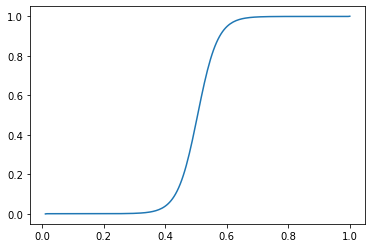

In [21]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [22]:
%load_ext autoreload
%autoreload 1
%aimport metrics

In [27]:
res_metrics = []
res_auc = []
for i in range(10):

    alphas = np.linspace(0, 1, 11)
    alpha_dict_metrics = {}
    alpha_dict_auc = {}


    for alpha in alphas:

        model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
        loss_function = CustomLoss(alpha=alpha)
        model_LSTM_custom.to(device)

        model_LSTM_custom, (loss_list, acc_list, 
                            overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)


        test_batch_size = 64
        final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

        (fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
         delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                               threshold_list, LSTM_flag=True)

        alpha_dict_metrics[alpha] = (fp_delay_list_LSTM_custom, delay_list_LSTM_custom)

        alpha_dict_auc[alpha] = metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)
    res_metrics.append(alpha_dict_metrics)
    res_auc.append(alpha_dict_auc)

Epoch: 2/60... Step: 5... Loss: -1.845205... Val Loss: -2.230045
Epoch: 4/60... Step: 10... Loss: -2.474927... Val Loss: -3.153111
Epoch: 5/60... Step: 15... Loss: -2.827273... Val Loss: -3.438227
Epoch: 7/60... Step: 20... Loss: -3.080391... Val Loss: -4.773548
Epoch: 9/60... Step: 25... Loss: -6.505666... Val Loss: -5.741946
Epoch: 10/60... Step: 30... Loss: -6.044250... Val Loss: -7.246948
Epoch: 12/60... Step: 35... Loss: -8.438200... Val Loss: -8.651469
Epoch: 14/60... Step: 40... Loss: -7.733449... Val Loss: -6.900047
Epoch: 15/60... Step: 45... Loss: -9.139668... Val Loss: -11.431345
Epoch: 17/60... Step: 50... Loss: -11.168674... Val Loss: -13.652884
Epoch: 19/60... Step: 55... Loss: -11.116717... Val Loss: -11.519274
Epoch: 20/60... Step: 60... Loss: -11.545874... Val Loss: -13.105406
Epoch: 22/60... Step: 65... Loss: -10.984411... Val Loss: -13.349648
Epoch: 24/60... Step: 70... Loss: -11.569747... Val Loss: -11.930141
Epoch: 25/60... Step: 75... Loss: -8.430677... Val Loss: 

Epoch: 22/60... Step: 65... Loss: -11.984167... Val Loss: -15.210988
Epoch: 24/60... Step: 70... Loss: -12.814158... Val Loss: -12.254211
Epoch: 25/60... Step: 75... Loss: -13.789684... Val Loss: -14.148982
Epoch: 27/60... Step: 80... Loss: -14.157542... Val Loss: -13.593910
Epoch: 29/60... Step: 85... Loss: -11.438679... Val Loss: -16.321795
Epoch: 30/60... Step: 90... Loss: -11.407269... Val Loss: -13.958552
Epoch: 32/60... Step: 95... Loss: -9.627208... Val Loss: -13.332701
Epoch: 34/60... Step: 100... Loss: -11.296634... Val Loss: -11.409251
Epoch: 35/60... Step: 105... Loss: -14.078732... Val Loss: -14.429118
Epoch: 37/60... Step: 110... Loss: -14.728558... Val Loss: -14.927483
Epoch: 39/60... Step: 115... Loss: -13.864459... Val Loss: -14.893794
Epoch: 40/60... Step: 120... Loss: -11.762492... Val Loss: -14.936546
Epoch: 42/60... Step: 125... Loss: -12.696342... Val Loss: -14.219401
Epoch: 44/60... Step: 130... Loss: -15.955747... Val Loss: -14.318838
Epoch: 45/60... Step: 135...

Epoch: 40/60... Step: 120... Loss: -10.028026... Val Loss: -11.301204
Epoch: 42/60... Step: 125... Loss: -14.376718... Val Loss: -14.067331
Epoch: 44/60... Step: 130... Loss: -12.279759... Val Loss: -13.505351
Epoch: 45/60... Step: 135... Loss: -11.753334... Val Loss: -12.660391
Epoch: 47/60... Step: 140... Loss: -13.252641... Val Loss: -13.364308
Epoch: 49/60... Step: 145... Loss: -14.673031... Val Loss: -15.108412
Epoch: 50/60... Step: 150... Loss: -14.745073... Val Loss: -15.026870
Epoch: 52/60... Step: 155... Loss: -11.662925... Val Loss: -14.609052
Epoch: 54/60... Step: 160... Loss: -13.445429... Val Loss: -18.356548
Epoch: 55/60... Step: 165... Loss: -15.100230... Val Loss: -12.604595
Epoch: 57/60... Step: 170... Loss: -14.229599... Val Loss: -16.267094
Epoch: 59/60... Step: 175... Loss: -14.627836... Val Loss: -14.222752
Epoch: 60/60... Step: 180... Loss: -13.983345... Val Loss: -14.981918
Epoch: 2/60... Step: 5... Loss: -2.027640... Val Loss: -2.129768
Epoch: 4/60... Step: 10..

Epoch: 59/60... Step: 175... Loss: -13.667134... Val Loss: -13.379463
Epoch: 60/60... Step: 180... Loss: -12.989106... Val Loss: -13.944563
Epoch: 2/60... Step: 5... Loss: -2.246376... Val Loss: -2.568504
Epoch: 4/60... Step: 10... Loss: -2.901964... Val Loss: -3.044314
Epoch: 5/60... Step: 15... Loss: -2.738581... Val Loss: -4.494269
Epoch: 7/60... Step: 20... Loss: -4.738986... Val Loss: -5.698008
Epoch: 9/60... Step: 25... Loss: -5.861246... Val Loss: -7.128372
Epoch: 10/60... Step: 30... Loss: -7.546361... Val Loss: -8.901012
Epoch: 12/60... Step: 35... Loss: -10.199814... Val Loss: -11.053123
Epoch: 14/60... Step: 40... Loss: -11.612986... Val Loss: -11.455742
Epoch: 15/60... Step: 45... Loss: -10.646222... Val Loss: -11.917636
Epoch: 17/60... Step: 50... Loss: -13.911677... Val Loss: -12.831832
Epoch: 19/60... Step: 55... Loss: -8.956335... Val Loss: -13.635324
Epoch: 20/60... Step: 60... Loss: -11.889737... Val Loss: -13.225666
Epoch: 22/60... Step: 65... Loss: -10.498971... Val

Epoch: 19/60... Step: 55... Loss: -12.906272... Val Loss: -13.374840
Epoch: 20/60... Step: 60... Loss: -9.210750... Val Loss: -14.580003
Epoch: 22/60... Step: 65... Loss: -11.757538... Val Loss: -13.931289
Epoch: 24/60... Step: 70... Loss: -13.168054... Val Loss: -14.967111
Epoch: 25/60... Step: 75... Loss: -12.275783... Val Loss: -16.061743
Epoch: 27/60... Step: 80... Loss: -11.211211... Val Loss: -13.314069
Epoch: 29/60... Step: 85... Loss: -10.718361... Val Loss: -14.822643
Epoch: 30/60... Step: 90... Loss: -13.760710... Val Loss: -14.532260
Epoch: 32/60... Step: 95... Loss: -11.323922... Val Loss: -17.537476
Epoch: 34/60... Step: 100... Loss: -12.736050... Val Loss: -13.397271
Epoch: 35/60... Step: 105... Loss: -11.913090... Val Loss: -15.041856
Epoch: 37/60... Step: 110... Loss: -12.787724... Val Loss: -14.708859
Epoch: 39/60... Step: 115... Loss: -14.459509... Val Loss: -14.428534
Epoch: 40/60... Step: 120... Loss: -12.195538... Val Loss: -15.027223
Epoch: 42/60... Step: 125... L

Epoch: 37/60... Step: 110... Loss: -13.006436... Val Loss: -13.951897
Epoch: 39/60... Step: 115... Loss: -13.623629... Val Loss: -12.793479
Epoch: 40/60... Step: 120... Loss: -13.014673... Val Loss: -15.159580
Epoch: 42/60... Step: 125... Loss: -8.483815... Val Loss: -13.102484
Epoch: 44/60... Step: 130... Loss: -12.738524... Val Loss: -16.721304
Epoch: 45/60... Step: 135... Loss: -11.765156... Val Loss: -13.465998
Epoch: 47/60... Step: 140... Loss: -12.177272... Val Loss: -13.944506
Epoch: 49/60... Step: 145... Loss: -14.044525... Val Loss: -11.935691
Epoch: 50/60... Step: 150... Loss: -13.979245... Val Loss: -13.934721
Epoch: 52/60... Step: 155... Loss: -13.415534... Val Loss: -15.046782
Epoch: 54/60... Step: 160... Loss: -14.287291... Val Loss: -12.878079
Epoch: 55/60... Step: 165... Loss: -12.742541... Val Loss: -10.884604
Epoch: 57/60... Step: 170... Loss: -12.275966... Val Loss: -15.965292
Epoch: 59/60... Step: 175... Loss: -14.449788... Val Loss: -12.708929
Epoch: 60/60... Step:

Epoch: 55/60... Step: 165... Loss: -14.568352... Val Loss: -14.980911
Epoch: 57/60... Step: 170... Loss: -10.859953... Val Loss: -15.287971
Epoch: 59/60... Step: 175... Loss: -11.841555... Val Loss: -14.278725
Epoch: 60/60... Step: 180... Loss: -14.382518... Val Loss: -14.722883
Epoch: 2/60... Step: 5... Loss: -2.224446... Val Loss: -2.369952
Epoch: 4/60... Step: 10... Loss: -3.000015... Val Loss: -3.712493
Epoch: 5/60... Step: 15... Loss: -2.676408... Val Loss: -4.284528
Epoch: 7/60... Step: 20... Loss: -4.199240... Val Loss: -5.889371
Epoch: 9/60... Step: 25... Loss: -5.756126... Val Loss: -6.492404
Epoch: 10/60... Step: 30... Loss: -6.891558... Val Loss: -7.080695
Epoch: 12/60... Step: 35... Loss: -8.120226... Val Loss: -8.949756
Epoch: 14/60... Step: 40... Loss: -7.218141... Val Loss: -9.025552
Epoch: 15/60... Step: 45... Loss: -7.678681... Val Loss: -13.468031
Epoch: 17/60... Step: 50... Loss: -9.736078... Val Loss: -12.692425
Epoch: 19/60... Step: 55... Loss: -11.372811... Val Lo

Epoch: 15/60... Step: 45... Loss: -9.530821... Val Loss: -11.185454
Epoch: 17/60... Step: 50... Loss: -11.413540... Val Loss: -11.374909
Epoch: 19/60... Step: 55... Loss: -11.084876... Val Loss: -13.951735
Epoch: 20/60... Step: 60... Loss: -11.759554... Val Loss: -11.382502
Epoch: 22/60... Step: 65... Loss: -12.756436... Val Loss: -17.181772
Epoch: 24/60... Step: 70... Loss: -10.803198... Val Loss: -12.918378
Epoch: 25/60... Step: 75... Loss: -13.639267... Val Loss: -15.720656
Epoch: 27/60... Step: 80... Loss: -12.935483... Val Loss: -13.498685
Epoch: 29/60... Step: 85... Loss: -14.171726... Val Loss: -13.147334
Epoch: 30/60... Step: 90... Loss: -11.586340... Val Loss: -12.971287
Epoch: 32/60... Step: 95... Loss: -9.977013... Val Loss: -8.242833
Epoch: 34/60... Step: 100... Loss: -12.225134... Val Loss: -15.186563
Epoch: 35/60... Step: 105... Loss: -12.832881... Val Loss: -14.989904
Epoch: 37/60... Step: 110... Loss: -11.830696... Val Loss: -15.074947
Epoch: 39/60... Step: 115... Loss:

Epoch: 35/60... Step: 105... Loss: -12.608014... Val Loss: -15.517159
Epoch: 37/60... Step: 110... Loss: -10.670807... Val Loss: -14.639508
Epoch: 39/60... Step: 115... Loss: -11.050197... Val Loss: -13.882968
Epoch: 40/60... Step: 120... Loss: -12.336610... Val Loss: -13.761147
Epoch: 42/60... Step: 125... Loss: -13.698845... Val Loss: -15.742187
Epoch: 44/60... Step: 130... Loss: -10.744423... Val Loss: -15.268064
Epoch: 45/60... Step: 135... Loss: -14.038495... Val Loss: -14.624206
Epoch: 47/60... Step: 140... Loss: -12.981659... Val Loss: -13.445217
Epoch: 49/60... Step: 145... Loss: -15.871624... Val Loss: -13.349180
Epoch: 50/60... Step: 150... Loss: -15.586987... Val Loss: -15.291500
Epoch: 52/60... Step: 155... Loss: -11.788203... Val Loss: -13.393682
Epoch: 54/60... Step: 160... Loss: -14.034037... Val Loss: -14.327433
Epoch: 55/60... Step: 165... Loss: -15.960658... Val Loss: -13.559921
Epoch: 57/60... Step: 170... Loss: -15.829061... Val Loss: -15.423329
Epoch: 59/60... Step

Epoch: 54/60... Step: 160... Loss: -13.776222... Val Loss: -15.422441
Epoch: 55/60... Step: 165... Loss: -12.826145... Val Loss: -15.462425
Epoch: 57/60... Step: 170... Loss: -14.443939... Val Loss: -15.192328
Epoch: 59/60... Step: 175... Loss: -13.789702... Val Loss: -16.354919
Epoch: 60/60... Step: 180... Loss: -16.202297... Val Loss: -14.656157
Epoch: 2/60... Step: 5... Loss: -1.662178... Val Loss: -2.034683
Epoch: 4/60... Step: 10... Loss: -1.872934... Val Loss: -2.516676
Epoch: 5/60... Step: 15... Loss: -2.472888... Val Loss: -3.049436
Epoch: 7/60... Step: 20... Loss: -2.612082... Val Loss: -3.358814
Epoch: 9/60... Step: 25... Loss: -3.101471... Val Loss: -4.869053
Epoch: 10/60... Step: 30... Loss: -4.367792... Val Loss: -6.990399
Epoch: 12/60... Step: 35... Loss: -6.316607... Val Loss: -7.722515
Epoch: 14/60... Step: 40... Loss: -8.275329... Val Loss: -8.864221
Epoch: 15/60... Step: 45... Loss: -11.855185... Val Loss: -10.434779
Epoch: 17/60... Step: 50... Loss: -10.054310... Val

Epoch: 14/60... Step: 40... Loss: -8.882977... Val Loss: -9.459319
Epoch: 15/60... Step: 45... Loss: -10.206173... Val Loss: -11.032391
Epoch: 17/60... Step: 50... Loss: -11.860461... Val Loss: -9.607450
Epoch: 19/60... Step: 55... Loss: -11.371128... Val Loss: -13.091315
Epoch: 20/60... Step: 60... Loss: -11.287994... Val Loss: -14.018704
Epoch: 22/60... Step: 65... Loss: -15.230914... Val Loss: -12.807463
Epoch: 24/60... Step: 70... Loss: -11.029713... Val Loss: -12.882117
Epoch: 25/60... Step: 75... Loss: -12.350780... Val Loss: -13.731694
Epoch: 27/60... Step: 80... Loss: -11.271549... Val Loss: -12.525633
Epoch: 29/60... Step: 85... Loss: -12.563646... Val Loss: -13.310110
Epoch: 30/60... Step: 90... Loss: -12.960835... Val Loss: -12.854647
Epoch: 32/60... Step: 95... Loss: -14.305902... Val Loss: -14.892514
Epoch: 34/60... Step: 100... Loss: -16.778288... Val Loss: -12.550347
Epoch: 35/60... Step: 105... Loss: -11.214136... Val Loss: -13.628187
Epoch: 37/60... Step: 110... Loss: 

Epoch: 34/60... Step: 100... Loss: -14.410345... Val Loss: -15.289778
Epoch: 35/60... Step: 105... Loss: -10.571692... Val Loss: -7.757753
Epoch: 37/60... Step: 110... Loss: -11.634139... Val Loss: -15.003810
Epoch: 39/60... Step: 115... Loss: -14.607790... Val Loss: -14.793287
Epoch: 40/60... Step: 120... Loss: -14.059163... Val Loss: -15.298981
Epoch: 42/60... Step: 125... Loss: -13.586439... Val Loss: -13.844332
Epoch: 44/60... Step: 130... Loss: -11.466211... Val Loss: -14.188906
Epoch: 45/60... Step: 135... Loss: -14.150963... Val Loss: -13.648575
Epoch: 47/60... Step: 140... Loss: -14.884066... Val Loss: -15.828773
Epoch: 49/60... Step: 145... Loss: -11.160144... Val Loss: -12.477106
Epoch: 50/60... Step: 150... Loss: -12.935840... Val Loss: -16.105202
Epoch: 52/60... Step: 155... Loss: -13.701647... Val Loss: -16.381058
Epoch: 54/60... Step: 160... Loss: -12.714653... Val Loss: -15.706139
Epoch: 55/60... Step: 165... Loss: -14.497580... Val Loss: -17.439163
Epoch: 57/60... Step:

Epoch: 54/60... Step: 160... Loss: -12.941098... Val Loss: -15.825852
Epoch: 55/60... Step: 165... Loss: -15.363715... Val Loss: -16.123163
Epoch: 57/60... Step: 170... Loss: -14.172692... Val Loss: -11.433156
Epoch: 59/60... Step: 175... Loss: -15.531731... Val Loss: -16.346100
Epoch: 60/60... Step: 180... Loss: -13.830161... Val Loss: -16.914995
Epoch: 2/60... Step: 5... Loss: -1.639629... Val Loss: -2.141424
Epoch: 4/60... Step: 10... Loss: -1.821237... Val Loss: -2.801310
Epoch: 5/60... Step: 15... Loss: -2.452304... Val Loss: -3.792187
Epoch: 7/60... Step: 20... Loss: -3.709047... Val Loss: -5.849525
Epoch: 9/60... Step: 25... Loss: -5.736728... Val Loss: -6.216037
Epoch: 10/60... Step: 30... Loss: -6.496229... Val Loss: -7.322649
Epoch: 12/60... Step: 35... Loss: -8.411883... Val Loss: -9.216196
Epoch: 14/60... Step: 40... Loss: -8.698552... Val Loss: -12.773296
Epoch: 15/60... Step: 45... Loss: -13.017386... Val Loss: -14.307120
Epoch: 17/60... Step: 50... Loss: -13.333953... Va

Epoch: 14/60... Step: 40... Loss: -7.537637... Val Loss: -13.370222
Epoch: 15/60... Step: 45... Loss: -10.778230... Val Loss: -11.515473
Epoch: 17/60... Step: 50... Loss: -12.446467... Val Loss: -15.360384
Epoch: 19/60... Step: 55... Loss: -11.016513... Val Loss: -13.717520
Epoch: 20/60... Step: 60... Loss: -9.760830... Val Loss: -14.869524
Epoch: 22/60... Step: 65... Loss: -13.139925... Val Loss: -14.389038
Epoch: 24/60... Step: 70... Loss: -10.979722... Val Loss: -12.856750
Epoch: 25/60... Step: 75... Loss: -13.282128... Val Loss: -12.823449
Epoch: 27/60... Step: 80... Loss: -12.129010... Val Loss: -14.345995
Epoch: 29/60... Step: 85... Loss: -15.914398... Val Loss: -14.644414
Epoch: 30/60... Step: 90... Loss: -15.139511... Val Loss: -12.242539
Epoch: 32/60... Step: 95... Loss: -9.505321... Val Loss: -16.692238
Epoch: 34/60... Step: 100... Loss: -14.013367... Val Loss: -13.786093
Epoch: 35/60... Step: 105... Loss: -12.278179... Val Loss: -13.110012
Epoch: 37/60... Step: 110... Loss: 

Epoch: 34/60... Step: 100... Loss: -12.807146... Val Loss: -14.833801
Epoch: 35/60... Step: 105... Loss: -11.944924... Val Loss: -11.471212
Epoch: 37/60... Step: 110... Loss: -13.375010... Val Loss: -13.522494
Epoch: 39/60... Step: 115... Loss: -13.913956... Val Loss: -11.889853
Epoch: 40/60... Step: 120... Loss: -13.955183... Val Loss: -15.837521
Epoch: 42/60... Step: 125... Loss: -14.325431... Val Loss: -13.672947
Epoch: 44/60... Step: 130... Loss: -13.245473... Val Loss: -14.833978
Epoch: 45/60... Step: 135... Loss: -13.278804... Val Loss: -13.662653
Epoch: 47/60... Step: 140... Loss: -12.122153... Val Loss: -13.408434
Epoch: 49/60... Step: 145... Loss: -15.379569... Val Loss: -17.652687
Epoch: 50/60... Step: 150... Loss: -14.241124... Val Loss: -16.687794
Epoch: 52/60... Step: 155... Loss: -14.708706... Val Loss: -13.130297
Epoch: 54/60... Step: 160... Loss: -15.136137... Val Loss: -11.598629
Epoch: 55/60... Step: 165... Loss: -14.911516... Val Loss: -15.562532
Epoch: 57/60... Step

Epoch: 52/60... Step: 155... Loss: -13.929571... Val Loss: -14.428069
Epoch: 54/60... Step: 160... Loss: -13.227130... Val Loss: -13.376833
Epoch: 55/60... Step: 165... Loss: -15.018303... Val Loss: -16.147087
Epoch: 57/60... Step: 170... Loss: -17.412357... Val Loss: -15.265618
Epoch: 59/60... Step: 175... Loss: -11.472890... Val Loss: -16.574625
Epoch: 60/60... Step: 180... Loss: -14.875034... Val Loss: -13.933728
Epoch: 2/60... Step: 5... Loss: -2.195096... Val Loss: -2.655265
Epoch: 4/60... Step: 10... Loss: -2.037502... Val Loss: -3.374284
Epoch: 5/60... Step: 15... Loss: -2.831799... Val Loss: -4.240972
Epoch: 7/60... Step: 20... Loss: -4.797246... Val Loss: -5.944463
Epoch: 9/60... Step: 25... Loss: -6.350870... Val Loss: -7.633717
Epoch: 10/60... Step: 30... Loss: -8.798336... Val Loss: -9.464653
Epoch: 12/60... Step: 35... Loss: -9.844217... Val Loss: -11.175504
Epoch: 14/60... Step: 40... Loss: -10.684994... Val Loss: -10.684535
Epoch: 15/60... Step: 45... Loss: -13.133829...

Epoch: 12/60... Step: 35... Loss: -8.927997... Val Loss: -10.326473
Epoch: 14/60... Step: 40... Loss: -6.978112... Val Loss: -9.404198
Epoch: 15/60... Step: 45... Loss: -9.688208... Val Loss: -9.775383
Epoch: 17/60... Step: 50... Loss: -10.323953... Val Loss: -10.411224
Epoch: 19/60... Step: 55... Loss: -10.966866... Val Loss: -11.477752
Epoch: 20/60... Step: 60... Loss: -11.544141... Val Loss: -13.023369
Epoch: 22/60... Step: 65... Loss: -11.646338... Val Loss: -13.717522
Epoch: 24/60... Step: 70... Loss: -12.533062... Val Loss: -10.771111
Epoch: 25/60... Step: 75... Loss: -12.860903... Val Loss: -13.709564
Epoch: 27/60... Step: 80... Loss: -13.014977... Val Loss: -12.992294
Epoch: 29/60... Step: 85... Loss: -11.833349... Val Loss: -13.121546
Epoch: 30/60... Step: 90... Loss: -12.500104... Val Loss: -13.321438
Epoch: 32/60... Step: 95... Loss: -11.855863... Val Loss: -15.117012
Epoch: 34/60... Step: 100... Loss: -12.474803... Val Loss: -15.063555
Epoch: 35/60... Step: 105... Loss: -15

Epoch: 32/60... Step: 95... Loss: -14.436459... Val Loss: -13.774023
Epoch: 34/60... Step: 100... Loss: -13.395550... Val Loss: -15.448269
Epoch: 35/60... Step: 105... Loss: -13.422043... Val Loss: -13.473255
Epoch: 37/60... Step: 110... Loss: -15.312309... Val Loss: -14.450113
Epoch: 39/60... Step: 115... Loss: -13.087083... Val Loss: -13.900604
Epoch: 40/60... Step: 120... Loss: -10.661046... Val Loss: -14.879006
Epoch: 42/60... Step: 125... Loss: -14.604097... Val Loss: -14.587729
Epoch: 44/60... Step: 130... Loss: -13.046466... Val Loss: -15.642707
Epoch: 45/60... Step: 135... Loss: -13.064070... Val Loss: -14.187806
Epoch: 47/60... Step: 140... Loss: -14.434250... Val Loss: -15.385779
Epoch: 49/60... Step: 145... Loss: -12.909604... Val Loss: -14.060565
Epoch: 50/60... Step: 150... Loss: -12.884254... Val Loss: -14.713723
Epoch: 52/60... Step: 155... Loss: -13.456049... Val Loss: -16.293001
Epoch: 54/60... Step: 160... Loss: -12.842680... Val Loss: -16.430382
Epoch: 55/60... Step:

Epoch: 50/60... Step: 150... Loss: -12.962806... Val Loss: -15.297815
Epoch: 52/60... Step: 155... Loss: -16.429029... Val Loss: -16.997652
Epoch: 54/60... Step: 160... Loss: -15.120605... Val Loss: -13.808380
Epoch: 55/60... Step: 165... Loss: -13.936128... Val Loss: -14.131987
Epoch: 57/60... Step: 170... Loss: -12.643946... Val Loss: -17.259827
Epoch: 59/60... Step: 175... Loss: -15.060732... Val Loss: -14.587682
Epoch: 60/60... Step: 180... Loss: -13.169065... Val Loss: -17.678089
Epoch: 2/60... Step: 5... Loss: -2.322421... Val Loss: -2.144249
Epoch: 4/60... Step: 10... Loss: -2.309719... Val Loss: -3.250216
Epoch: 5/60... Step: 15... Loss: -2.306166... Val Loss: -3.495005
Epoch: 7/60... Step: 20... Loss: -4.181425... Val Loss: -3.997649
Epoch: 9/60... Step: 25... Loss: -4.223706... Val Loss: -6.006440
Epoch: 10/60... Step: 30... Loss: -6.265610... Val Loss: -7.590721
Epoch: 12/60... Step: 35... Loss: -8.731346... Val Loss: -7.886278
Epoch: 14/60... Step: 40... Loss: -10.831242...

Epoch: 10/60... Step: 30... Loss: -7.697276... Val Loss: -8.235827
Epoch: 12/60... Step: 35... Loss: -8.425678... Val Loss: -11.354873
Epoch: 14/60... Step: 40... Loss: -11.883218... Val Loss: -11.126348
Epoch: 15/60... Step: 45... Loss: -11.630065... Val Loss: -14.757084
Epoch: 17/60... Step: 50... Loss: -9.840786... Val Loss: -12.865353
Epoch: 19/60... Step: 55... Loss: -12.130414... Val Loss: -13.011438
Epoch: 20/60... Step: 60... Loss: -12.492842... Val Loss: -15.223306
Epoch: 22/60... Step: 65... Loss: -12.014525... Val Loss: -13.785602
Epoch: 24/60... Step: 70... Loss: -14.081478... Val Loss: -13.272392
Epoch: 25/60... Step: 75... Loss: -13.085468... Val Loss: -14.024557
Epoch: 27/60... Step: 80... Loss: -13.321320... Val Loss: -12.806872
Epoch: 29/60... Step: 85... Loss: -13.253403... Val Loss: -14.466843
Epoch: 30/60... Step: 90... Loss: -15.008416... Val Loss: -14.341039
Epoch: 32/60... Step: 95... Loss: -12.844299... Val Loss: -13.066118
Epoch: 34/60... Step: 100... Loss: -11

Epoch: 30/60... Step: 90... Loss: -13.380215... Val Loss: -12.349814
Epoch: 32/60... Step: 95... Loss: -13.057134... Val Loss: -11.899161
Epoch: 34/60... Step: 100... Loss: -12.882860... Val Loss: -14.948655
Epoch: 35/60... Step: 105... Loss: -11.328333... Val Loss: -16.350445
Epoch: 37/60... Step: 110... Loss: -15.091457... Val Loss: -15.641217
Epoch: 39/60... Step: 115... Loss: -12.800535... Val Loss: -11.676270
Epoch: 40/60... Step: 120... Loss: -13.813093... Val Loss: -8.145865
Epoch: 42/60... Step: 125... Loss: -10.698410... Val Loss: -16.364397
Epoch: 44/60... Step: 130... Loss: -13.081702... Val Loss: -15.274365
Epoch: 45/60... Step: 135... Loss: -12.265523... Val Loss: -15.229013
Epoch: 47/60... Step: 140... Loss: -15.133523... Val Loss: -13.490625
Epoch: 49/60... Step: 145... Loss: -15.915085... Val Loss: -15.332958
Epoch: 50/60... Step: 150... Loss: -15.758116... Val Loss: -13.800396
Epoch: 52/60... Step: 155... Loss: -13.447837... Val Loss: -14.864318
Epoch: 54/60... Step: 1

Epoch: 12/60... Step: 35... Loss: -7.385153... Val Loss: -10.291327
Epoch: 14/60... Step: 40... Loss: -10.043037... Val Loss: -10.335616
Epoch: 15/60... Step: 45... Loss: -10.674959... Val Loss: -12.022087
Epoch: 17/60... Step: 50... Loss: -11.729651... Val Loss: -12.651302
Epoch: 19/60... Step: 55... Loss: -10.900648... Val Loss: -14.179372
Epoch: 20/60... Step: 60... Loss: -12.925596... Val Loss: -14.098752
Epoch: 22/60... Step: 65... Loss: -12.524803... Val Loss: -14.596124
Epoch: 24/60... Step: 70... Loss: -14.867292... Val Loss: -13.547634
Epoch: 25/60... Step: 75... Loss: -12.911968... Val Loss: -12.651122
Epoch: 27/60... Step: 80... Loss: -12.460883... Val Loss: -15.595369
Epoch: 29/60... Step: 85... Loss: -11.973053... Val Loss: -14.771069
Epoch: 30/60... Step: 90... Loss: -11.007645... Val Loss: -14.889854
Epoch: 32/60... Step: 95... Loss: -13.095368... Val Loss: -16.489016
Epoch: 34/60... Step: 100... Loss: -13.459636... Val Loss: -10.541372
Epoch: 35/60... Step: 105... Loss:

Epoch: 32/60... Step: 95... Loss: -12.454487... Val Loss: -11.496297
Epoch: 34/60... Step: 100... Loss: -11.213550... Val Loss: -11.949438
Epoch: 35/60... Step: 105... Loss: -11.555014... Val Loss: -10.535742
Epoch: 37/60... Step: 110... Loss: -14.111258... Val Loss: -15.612982
Epoch: 39/60... Step: 115... Loss: -15.675068... Val Loss: -15.258636
Epoch: 40/60... Step: 120... Loss: -13.158343... Val Loss: -15.061264
Epoch: 42/60... Step: 125... Loss: -13.378572... Val Loss: -13.386546
Epoch: 44/60... Step: 130... Loss: -13.240127... Val Loss: -14.590639
Epoch: 45/60... Step: 135... Loss: -12.720102... Val Loss: -15.530666
Epoch: 47/60... Step: 140... Loss: -12.864625... Val Loss: -16.025120
Epoch: 49/60... Step: 145... Loss: -13.210124... Val Loss: -17.002802
Epoch: 50/60... Step: 150... Loss: -12.652976... Val Loss: -15.138971
Epoch: 52/60... Step: 155... Loss: -12.947054... Val Loss: -15.714054
Epoch: 54/60... Step: 160... Loss: -11.903221... Val Loss: -14.589483
Epoch: 55/60... Step:

Epoch: 50/60... Step: 150... Loss: -12.961516... Val Loss: -13.776302
Epoch: 52/60... Step: 155... Loss: -15.346872... Val Loss: -15.455043
Epoch: 54/60... Step: 160... Loss: -12.616742... Val Loss: -15.099226
Epoch: 55/60... Step: 165... Loss: -17.473843... Val Loss: -14.856690
Epoch: 57/60... Step: 170... Loss: -15.125255... Val Loss: -17.387854
Epoch: 59/60... Step: 175... Loss: -15.558727... Val Loss: -15.872993
Epoch: 60/60... Step: 180... Loss: -12.753877... Val Loss: -16.524944
Epoch: 2/60... Step: 5... Loss: -1.857667... Val Loss: -2.210560
Epoch: 4/60... Step: 10... Loss: -2.245914... Val Loss: -2.331525
Epoch: 5/60... Step: 15... Loss: -2.330667... Val Loss: -3.500399
Epoch: 7/60... Step: 20... Loss: -3.967554... Val Loss: -5.342374
Epoch: 9/60... Step: 25... Loss: -4.816182... Val Loss: -7.157582
Epoch: 10/60... Step: 30... Loss: -8.411594... Val Loss: -7.467016
Epoch: 12/60... Step: 35... Loss: -7.824978... Val Loss: -9.154059
Epoch: 14/60... Step: 40... Loss: -10.751857...

Epoch: 10/60... Step: 30... Loss: -7.572099... Val Loss: -7.907746
Epoch: 12/60... Step: 35... Loss: -6.386793... Val Loss: -9.687901
Epoch: 14/60... Step: 40... Loss: -9.818846... Val Loss: -11.662924
Epoch: 15/60... Step: 45... Loss: -7.760908... Val Loss: -12.684916
Epoch: 17/60... Step: 50... Loss: -11.749387... Val Loss: -11.654136
Epoch: 19/60... Step: 55... Loss: -11.355855... Val Loss: -12.630255
Epoch: 20/60... Step: 60... Loss: -11.762008... Val Loss: -13.816225
Epoch: 22/60... Step: 65... Loss: -10.892454... Val Loss: -13.862184
Epoch: 24/60... Step: 70... Loss: -9.411739... Val Loss: -12.725492
Epoch: 25/60... Step: 75... Loss: -13.556821... Val Loss: -10.664253
Epoch: 27/60... Step: 80... Loss: -12.817131... Val Loss: -10.806070
Epoch: 29/60... Step: 85... Loss: -6.497626... Val Loss: -12.331559
Epoch: 30/60... Step: 90... Loss: -10.217550... Val Loss: -12.275075
Epoch: 32/60... Step: 95... Loss: -11.655180... Val Loss: -11.718172
Epoch: 34/60... Step: 100... Loss: -11.545

Epoch: 30/60... Step: 90... Loss: -15.822558... Val Loss: -13.936578
Epoch: 32/60... Step: 95... Loss: -12.803427... Val Loss: -16.780184
Epoch: 34/60... Step: 100... Loss: -12.672290... Val Loss: -14.989855
Epoch: 35/60... Step: 105... Loss: -13.572691... Val Loss: -15.019910
Epoch: 37/60... Step: 110... Loss: -12.608348... Val Loss: -15.080685
Epoch: 39/60... Step: 115... Loss: -15.067399... Val Loss: -14.170470
Epoch: 40/60... Step: 120... Loss: -14.964800... Val Loss: -14.704737
Epoch: 42/60... Step: 125... Loss: -13.750159... Val Loss: -13.961185
Epoch: 44/60... Step: 130... Loss: -11.532357... Val Loss: -14.578028
Epoch: 45/60... Step: 135... Loss: -13.182966... Val Loss: -15.620710
Epoch: 47/60... Step: 140... Loss: -16.861813... Val Loss: -13.932279
Epoch: 49/60... Step: 145... Loss: -10.593025... Val Loss: -14.312454
Epoch: 50/60... Step: 150... Loss: -13.848683... Val Loss: -15.015319
Epoch: 52/60... Step: 155... Loss: -14.413468... Val Loss: -14.307173
Epoch: 54/60... Step: 

Epoch: 49/60... Step: 145... Loss: -10.733289... Val Loss: -12.893547
Epoch: 50/60... Step: 150... Loss: -13.767294... Val Loss: -12.281895
Epoch: 52/60... Step: 155... Loss: -16.962952... Val Loss: -13.475367
Epoch: 54/60... Step: 160... Loss: -14.775427... Val Loss: -14.276482
Epoch: 55/60... Step: 165... Loss: -14.517040... Val Loss: -17.726583
Epoch: 57/60... Step: 170... Loss: -15.700354... Val Loss: -15.598942
Epoch: 59/60... Step: 175... Loss: -16.825451... Val Loss: -15.671090
Epoch: 60/60... Step: 180... Loss: -15.374714... Val Loss: -15.456949
Epoch: 2/60... Step: 5... Loss: -1.509105... Val Loss: -2.544260
Epoch: 4/60... Step: 10... Loss: -2.436913... Val Loss: -3.491252
Epoch: 5/60... Step: 15... Loss: -3.293779... Val Loss: -3.648391
Epoch: 7/60... Step: 20... Loss: -3.441674... Val Loss: -4.851708
Epoch: 9/60... Step: 25... Loss: -5.482154... Val Loss: -6.052107
Epoch: 10/60... Step: 30... Loss: -6.505663... Val Loss: -7.145655
Epoch: 12/60... Step: 35... Loss: -8.130722.

Epoch: 7/60... Step: 20... Loss: -4.024199... Val Loss: -4.493604
Epoch: 9/60... Step: 25... Loss: -6.032929... Val Loss: -6.144543
Epoch: 10/60... Step: 30... Loss: -7.786001... Val Loss: -6.121676
Epoch: 12/60... Step: 35... Loss: -8.768524... Val Loss: -9.439271
Epoch: 14/60... Step: 40... Loss: -10.761554... Val Loss: -10.099277
Epoch: 15/60... Step: 45... Loss: -12.964185... Val Loss: -12.395751
Epoch: 17/60... Step: 50... Loss: -12.841984... Val Loss: -13.366291
Epoch: 19/60... Step: 55... Loss: -11.850107... Val Loss: -14.419580
Epoch: 20/60... Step: 60... Loss: -9.923108... Val Loss: -12.570377
Epoch: 22/60... Step: 65... Loss: -12.995981... Val Loss: -13.230701
Epoch: 24/60... Step: 70... Loss: -12.726445... Val Loss: -10.859386
Epoch: 25/60... Step: 75... Loss: -13.384700... Val Loss: -14.953605
Epoch: 27/60... Step: 80... Loss: -13.399402... Val Loss: -11.210032
Epoch: 29/60... Step: 85... Loss: -15.669849... Val Loss: -14.708351
Epoch: 30/60... Step: 90... Loss: -12.925211.

Epoch: 27/60... Step: 80... Loss: -11.287358... Val Loss: -16.073547
Epoch: 29/60... Step: 85... Loss: -16.003668... Val Loss: -15.205805
Epoch: 30/60... Step: 90... Loss: -13.989527... Val Loss: -17.038641
Epoch: 32/60... Step: 95... Loss: -12.657460... Val Loss: -12.075380
Epoch: 34/60... Step: 100... Loss: -14.293631... Val Loss: -14.818568
Epoch: 35/60... Step: 105... Loss: -16.845232... Val Loss: -15.622959
Epoch: 37/60... Step: 110... Loss: -13.415730... Val Loss: -14.725327
Epoch: 39/60... Step: 115... Loss: -12.570412... Val Loss: -18.636654
Epoch: 40/60... Step: 120... Loss: -10.911254... Val Loss: -15.001472
Epoch: 42/60... Step: 125... Loss: -16.061539... Val Loss: -16.308136
Epoch: 44/60... Step: 130... Loss: -14.907956... Val Loss: -14.846581
Epoch: 45/60... Step: 135... Loss: -14.605762... Val Loss: -12.129663
Epoch: 47/60... Step: 140... Loss: -11.806810... Val Loss: -16.668695
Epoch: 49/60... Step: 145... Loss: -16.238894... Val Loss: -15.807076
Epoch: 50/60... Step: 15

Epoch: 45/60... Step: 135... Loss: -16.422806... Val Loss: -15.447412
Epoch: 47/60... Step: 140... Loss: -11.615275... Val Loss: -16.266367
Epoch: 49/60... Step: 145... Loss: -14.860214... Val Loss: -14.079143
Epoch: 50/60... Step: 150... Loss: -11.481185... Val Loss: -13.606594
Epoch: 52/60... Step: 155... Loss: -13.528069... Val Loss: -15.521906
Epoch: 54/60... Step: 160... Loss: -12.898321... Val Loss: -17.069765
Epoch: 55/60... Step: 165... Loss: -13.899683... Val Loss: -17.436981
Epoch: 57/60... Step: 170... Loss: -13.560748... Val Loss: -16.461962
Epoch: 59/60... Step: 175... Loss: -15.984945... Val Loss: -12.640160
Epoch: 60/60... Step: 180... Loss: -13.819878... Val Loss: -15.204327
Epoch: 2/60... Step: 5... Loss: -2.195607... Val Loss: -2.391290
Epoch: 4/60... Step: 10... Loss: -2.369424... Val Loss: -2.752973
Epoch: 5/60... Step: 15... Loss: -2.522909... Val Loss: -2.241986
Epoch: 7/60... Step: 20... Loss: -3.504529... Val Loss: -3.574430
Epoch: 9/60... Step: 25... Loss: -3.6

Epoch: 4/60... Step: 10... Loss: -2.186080... Val Loss: -2.620173
Epoch: 5/60... Step: 15... Loss: -3.106203... Val Loss: -2.958006
Epoch: 7/60... Step: 20... Loss: -3.068675... Val Loss: -4.640963
Epoch: 9/60... Step: 25... Loss: -4.982138... Val Loss: -6.078987
Epoch: 10/60... Step: 30... Loss: -5.694013... Val Loss: -7.919950
Epoch: 12/60... Step: 35... Loss: -7.930977... Val Loss: -9.049384
Epoch: 14/60... Step: 40... Loss: -9.699718... Val Loss: -9.992918
Epoch: 15/60... Step: 45... Loss: -9.906608... Val Loss: -8.335405
Epoch: 17/60... Step: 50... Loss: -9.174114... Val Loss: -11.683454
Epoch: 19/60... Step: 55... Loss: -9.640278... Val Loss: -12.246815
Epoch: 20/60... Step: 60... Loss: -11.484256... Val Loss: -13.501630
Epoch: 22/60... Step: 65... Loss: -13.191685... Val Loss: -12.296690
Epoch: 24/60... Step: 70... Loss: -11.681972... Val Loss: -12.443949
Epoch: 25/60... Step: 75... Loss: -12.538809... Val Loss: -13.772034
Epoch: 27/60... Step: 80... Loss: -14.379847... Val Loss

Epoch: 24/60... Step: 70... Loss: -10.995311... Val Loss: -14.803707
Epoch: 25/60... Step: 75... Loss: -14.057756... Val Loss: -11.199043
Epoch: 27/60... Step: 80... Loss: -13.417294... Val Loss: -13.867312
Epoch: 29/60... Step: 85... Loss: -13.212980... Val Loss: -15.192437
Epoch: 30/60... Step: 90... Loss: -12.463984... Val Loss: -11.415422
Epoch: 32/60... Step: 95... Loss: -13.419865... Val Loss: -11.728318
Epoch: 34/60... Step: 100... Loss: -12.752962... Val Loss: -15.766858
Epoch: 35/60... Step: 105... Loss: -12.481744... Val Loss: -15.054250
Epoch: 37/60... Step: 110... Loss: -13.810744... Val Loss: -14.302957
Epoch: 39/60... Step: 115... Loss: -13.595136... Val Loss: -14.963154
Epoch: 40/60... Step: 120... Loss: -12.442155... Val Loss: -13.433732
Epoch: 42/60... Step: 125... Loss: -12.926558... Val Loss: -15.488751
Epoch: 44/60... Step: 130... Loss: -14.627710... Val Loss: -16.444008
Epoch: 45/60... Step: 135... Loss: -13.588859... Val Loss: -14.124750
Epoch: 47/60... Step: 140.

Epoch: 42/60... Step: 125... Loss: -13.370913... Val Loss: -15.378405
Epoch: 44/60... Step: 130... Loss: -11.670947... Val Loss: -14.666607
Epoch: 45/60... Step: 135... Loss: -13.762170... Val Loss: -14.242371
Epoch: 47/60... Step: 140... Loss: -12.487410... Val Loss: -15.482279
Epoch: 49/60... Step: 145... Loss: -11.022518... Val Loss: -13.794467
Epoch: 50/60... Step: 150... Loss: -12.429704... Val Loss: -15.730923
Epoch: 52/60... Step: 155... Loss: -13.189458... Val Loss: -15.303030
Epoch: 54/60... Step: 160... Loss: -12.619802... Val Loss: -15.494994
Epoch: 55/60... Step: 165... Loss: -13.804365... Val Loss: -14.366487
Epoch: 57/60... Step: 170... Loss: -14.908625... Val Loss: -12.879725
Epoch: 59/60... Step: 175... Loss: -10.953750... Val Loss: -13.521007
Epoch: 60/60... Step: 180... Loss: -12.283050... Val Loss: -13.666452
Epoch: 2/60... Step: 5... Loss: -2.274340... Val Loss: -2.315305
Epoch: 4/60... Step: 10... Loss: -2.874168... Val Loss: -3.223848
Epoch: 5/60... Step: 15... Lo

In [47]:
res_auc

10

In [66]:
final_res_alpha = {}
for alpha in alphas:
    curr_alpha = []
    for auc in res_auc[1:]:
        curr_alpha.append(auc[alpha])
    final_res_alpha[alpha] = curr_alpha
    
import pandas as pd
final_res_alpha = pd.DataFrame(final_res_alpha)
final_res_alpha.columns = np.round(final_res_alpha.columns, 2)    

In [85]:
final_res_alpha.to_csv('compare_alphas_9_runs.csv', index=False)

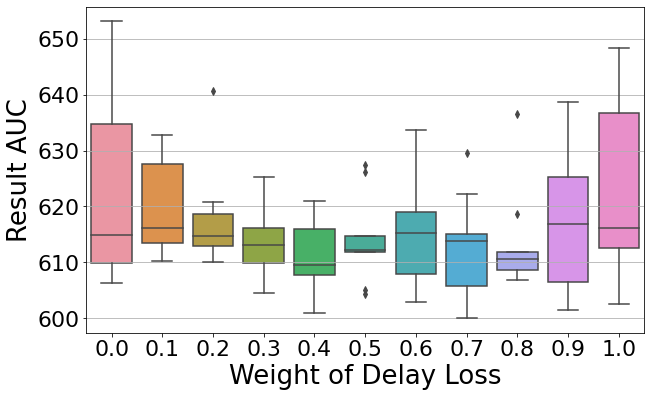

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_res_alpha)
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
plt.xlabel('Weight of Delay Loss', fontsize=26)
plt.ylabel('Result AUC', fontsize=26);
plt.grid(axis='y')
plt.savefig('compare_alphas.pdf', bbox_inches='tight')

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,614.945122,612.232470,612.891768,625.270960,615.994093,627.338986,607.841082,629.612805,608.650724,638.630335,602.447409
1,634.750191,630.482660,618.599848,609.905488,612.152820,611.822409,619.005526,613.873666,610.512005,616.825457,613.339177
2,610.412919,632.797828,614.725991,614.301258,615.935785,611.871570,605.426639,614.298971,618.619855,601.508765,609.676258
3,607.887576,613.489710,614.947599,616.101753,609.496189,626.076220,622.761242,610.185404,607.022866,609.436928,625.750953
4,634.961319,627.618331,613.099657,604.420922,609.232851,604.263910,633.726944,600.019627,606.820312,606.454840,648.360709
5,606.357279,610.150343,640.661395,613.002668,600.903201,612.217035,613.350229,605.774962,609.781822,628.495617,637.452934
6,618.802973,617.774390,620.722561,608.117950,607.653011,614.768674,615.510099,622.202553,636.488948,618.892721,616.190168
7,653.119855,613.609566,611.755907,612.594703,601.179878,605.104230,615.288300,615.100229,611.532203,604.148438,612.503430
8,609.879002,616.196265,610.077363,618.084604,620.980183,612.699123,602.857088,605.162348,611.796494,625.213034,636.640625


In [65]:
fps = []
delays = []
for alpha in alphas:
    fps.append(alpha_dict_metrics[alpha][0])
    delays.append(alpha_dict_metrics[alpha][1])    

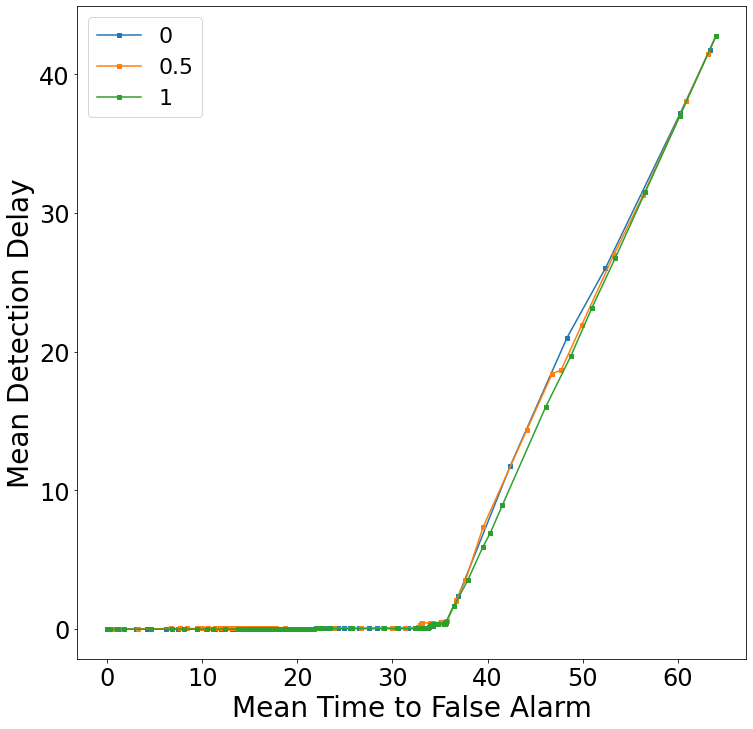

In [62]:
plt.figure(figsize=(12, 12))
for alpha in [0, 0.5, 1]:
    fp_delay_list_LSTM_custom, delay_list_LSTM_custom = alpha_dict_metrics[alpha]
    plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-s', markersize=4, label=alpha)

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=22);
#plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')

In [32]:
ws = [18, 16, 24, 32, 40, 48, 56, 64]
w_dict_metrics = {}
w_dict_auc = {}


for w in ws:

    model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
    loss_function = CustomLoss(w = w)
    model_LSTM_custom.to(device)

    model_LSTM_custom, (loss_list, acc_list, 
                        overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)


    test_batch_size = 64
    final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

    (fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
     delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                           threshold_list, LSTM_flag=True)

    w_dict_metrics[w] = (fp_delay_list_LSTM_custom, delay_list_LSTM_custom)

    w_dict_auc[w] = metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)

Epoch: 2/60... Step: 5... Loss: -2.439857... Val Loss: -2.475068
Epoch: 4/60... Step: 10... Loss: -3.165465... Val Loss: -3.942216
Epoch: 5/60... Step: 15... Loss: -3.820198... Val Loss: -4.292977
Epoch: 7/60... Step: 20... Loss: -3.837937... Val Loss: -5.490519
Epoch: 9/60... Step: 25... Loss: -6.076880... Val Loss: -7.816597
Epoch: 10/60... Step: 30... Loss: -7.390757... Val Loss: -9.299980
Epoch: 12/60... Step: 35... Loss: -7.512784... Val Loss: -11.045715
Epoch: 14/60... Step: 40... Loss: -10.546397... Val Loss: -13.270967
Epoch: 15/60... Step: 45... Loss: -14.235300... Val Loss: -12.720597
Epoch: 17/60... Step: 50... Loss: -12.238783... Val Loss: -10.999008
Epoch: 19/60... Step: 55... Loss: -10.397406... Val Loss: -12.206926
Epoch: 20/60... Step: 60... Loss: -12.164300... Val Loss: -10.259439
Epoch: 22/60... Step: 65... Loss: -11.422466... Val Loss: -13.463074
Epoch: 24/60... Step: 70... Loss: -14.635124... Val Loss: -13.231560
Epoch: 25/60... Step: 75... Loss: -14.799476... Val L

Epoch: 22/60... Step: 65... Loss: -11.643563... Val Loss: -13.979095
Epoch: 24/60... Step: 70... Loss: -11.003553... Val Loss: -12.460265
Epoch: 25/60... Step: 75... Loss: -9.619734... Val Loss: -15.313697
Epoch: 27/60... Step: 80... Loss: -9.484482... Val Loss: -15.195627
Epoch: 29/60... Step: 85... Loss: -13.207458... Val Loss: -14.552126
Epoch: 30/60... Step: 90... Loss: -13.407563... Val Loss: -13.930845
Epoch: 32/60... Step: 95... Loss: -13.016499... Val Loss: -14.907293
Epoch: 34/60... Step: 100... Loss: -13.805485... Val Loss: -11.452143
Epoch: 35/60... Step: 105... Loss: -11.146033... Val Loss: -12.836481
Epoch: 37/60... Step: 110... Loss: -11.216584... Val Loss: -14.219589
Epoch: 39/60... Step: 115... Loss: -11.052068... Val Loss: -13.397347
Epoch: 40/60... Step: 120... Loss: -13.665873... Val Loss: -11.588005
Epoch: 42/60... Step: 125... Loss: -13.647236... Val Loss: -14.627382
Epoch: 44/60... Step: 130... Loss: -11.827909... Val Loss: -13.955332
Epoch: 45/60... Step: 135... 

Epoch: 40/60... Step: 120... Loss: -11.727898... Val Loss: -15.779829
Epoch: 42/60... Step: 125... Loss: -11.426228... Val Loss: -13.761684
Epoch: 44/60... Step: 130... Loss: -11.124720... Val Loss: -15.465855
Epoch: 45/60... Step: 135... Loss: -14.648054... Val Loss: -15.943199
Epoch: 47/60... Step: 140... Loss: -14.608459... Val Loss: -14.648539
Epoch: 49/60... Step: 145... Loss: -14.554272... Val Loss: -14.929568
Epoch: 50/60... Step: 150... Loss: -12.854380... Val Loss: -13.535451
Epoch: 52/60... Step: 155... Loss: -11.782125... Val Loss: -16.113615
Epoch: 54/60... Step: 160... Loss: -11.739942... Val Loss: -17.078777
Epoch: 55/60... Step: 165... Loss: -13.898906... Val Loss: -15.522101
Epoch: 57/60... Step: 170... Loss: -11.009690... Val Loss: -14.709359
Epoch: 59/60... Step: 175... Loss: -14.473930... Val Loss: -14.753513
Epoch: 60/60... Step: 180... Loss: -12.290228... Val Loss: -16.284891
Epoch: 2/60... Step: 5... Loss: -1.748590... Val Loss: -2.359951
Epoch: 4/60... Step: 10..

In [33]:
w_dict_auc

{8: 622.7587652439024,
 16: 617.1865472560975,
 24: 607.0825076219512,
 32: 608.7551448170732,
 40: 617.0691692073171,
 48: 606.9030106707316,
 56: 611.9681783536586,
 64: 606.5533536585367}

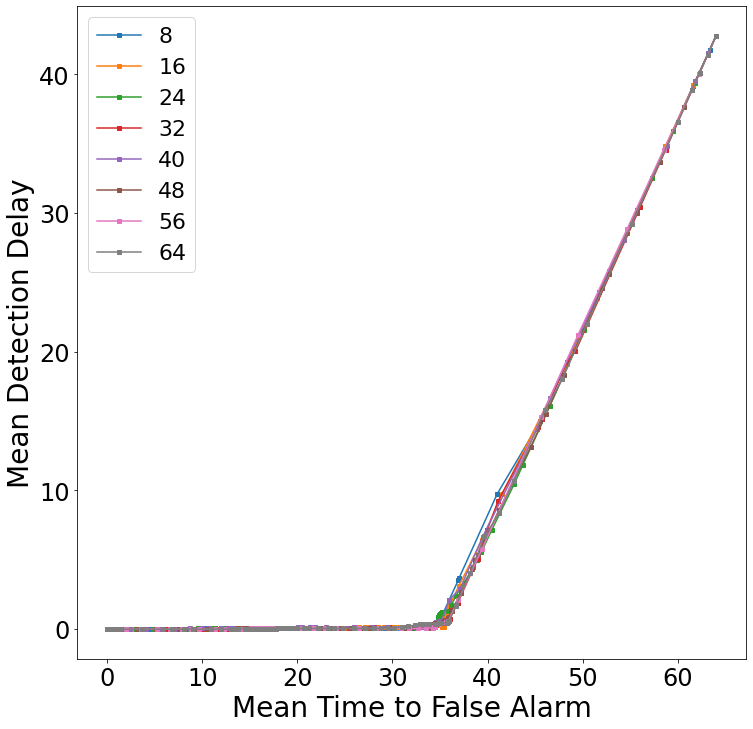

In [48]:
plt.figure(figsize=(12, 12))
for w in ws:
    fp_delay_list_LSTM_custom, delay_list_LSTM_custom = w_dict_metrics[w]
    plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-s', markersize=4, label=w)

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=22);
#plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')

In [79]:
ws_2 = [1, 2, 3, 4, 5, 6, 7, 8]


for w in ws_2:

    model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
    loss_function = CustomLoss(w = w)
    model_LSTM_custom.to(device)

    model_LSTM_custom, (loss_list, acc_list, 
                        overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)


    test_batch_size = 64
    final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

    (fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
     delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                           threshold_list, LSTM_flag=True)

    w_dict_metrics[w] = (fp_delay_list_LSTM_custom, delay_list_LSTM_custom)

    w_dict_auc[w] = metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)

Epoch: 2/60... Step: 5... Loss: -2.306885... Val Loss: -2.205899
Epoch: 4/60... Step: 10... Loss: -2.511154... Val Loss: -2.637514
Epoch: 5/60... Step: 15... Loss: -2.774004... Val Loss: -3.849810
Epoch: 7/60... Step: 20... Loss: -3.781294... Val Loss: -5.162499
Epoch: 9/60... Step: 25... Loss: -6.927928... Val Loss: -6.687344
Epoch: 10/60... Step: 30... Loss: -6.933115... Val Loss: -7.690290
Epoch: 12/60... Step: 35... Loss: -8.470315... Val Loss: -9.135942
Epoch: 14/60... Step: 40... Loss: -10.503770... Val Loss: -10.422122
Epoch: 15/60... Step: 45... Loss: -13.310269... Val Loss: -12.515209
Epoch: 17/60... Step: 50... Loss: -12.987867... Val Loss: -12.396361
Epoch: 19/60... Step: 55... Loss: -8.952909... Val Loss: -13.673643
Epoch: 20/60... Step: 60... Loss: -12.741362... Val Loss: -12.194077
Epoch: 22/60... Step: 65... Loss: -12.749469... Val Loss: -13.190862
Epoch: 24/60... Step: 70... Loss: -12.384612... Val Loss: -15.360291
Epoch: 25/60... Step: 75... Loss: -13.431170... Val Los

Epoch: 22/60... Step: 65... Loss: -13.916488... Val Loss: -12.059406
Epoch: 24/60... Step: 70... Loss: -12.789823... Val Loss: -13.577056
Epoch: 25/60... Step: 75... Loss: -11.948633... Val Loss: -10.230491
Epoch: 27/60... Step: 80... Loss: -11.370943... Val Loss: -12.399168
Epoch: 29/60... Step: 85... Loss: -12.673275... Val Loss: -13.948646
Epoch: 30/60... Step: 90... Loss: -13.867236... Val Loss: -14.870911
Epoch: 32/60... Step: 95... Loss: -15.045442... Val Loss: -14.551371
Epoch: 34/60... Step: 100... Loss: -14.858645... Val Loss: -14.762321
Epoch: 35/60... Step: 105... Loss: -11.863828... Val Loss: -16.759140
Epoch: 37/60... Step: 110... Loss: -15.314482... Val Loss: -15.218774
Epoch: 39/60... Step: 115... Loss: -15.234049... Val Loss: -14.830547
Epoch: 40/60... Step: 120... Loss: -11.951343... Val Loss: -14.619942
Epoch: 42/60... Step: 125... Loss: -14.011529... Val Loss: -14.774458
Epoch: 44/60... Step: 130... Loss: -10.855458... Val Loss: -11.936133
Epoch: 45/60... Step: 135..

Epoch: 40/60... Step: 120... Loss: -11.167702... Val Loss: -17.267561
Epoch: 42/60... Step: 125... Loss: -12.924634... Val Loss: -13.532811
Epoch: 44/60... Step: 130... Loss: -14.982878... Val Loss: -15.678179
Epoch: 45/60... Step: 135... Loss: -12.869349... Val Loss: -13.338396
Epoch: 47/60... Step: 140... Loss: -14.623124... Val Loss: -12.760317
Epoch: 49/60... Step: 145... Loss: -10.802761... Val Loss: -13.219234
Epoch: 50/60... Step: 150... Loss: -15.687524... Val Loss: -15.355391
Epoch: 52/60... Step: 155... Loss: -13.509407... Val Loss: -13.746906
Epoch: 54/60... Step: 160... Loss: -14.356365... Val Loss: -16.236389
Epoch: 55/60... Step: 165... Loss: -15.976159... Val Loss: -14.932537
Epoch: 57/60... Step: 170... Loss: -12.679253... Val Loss: -13.945994
Epoch: 59/60... Step: 175... Loss: -13.505765... Val Loss: -15.704794
Epoch: 60/60... Step: 180... Loss: -16.111803... Val Loss: -15.591428
Epoch: 2/60... Step: 5... Loss: -1.834480... Val Loss: -2.205325
Epoch: 4/60... Step: 10..

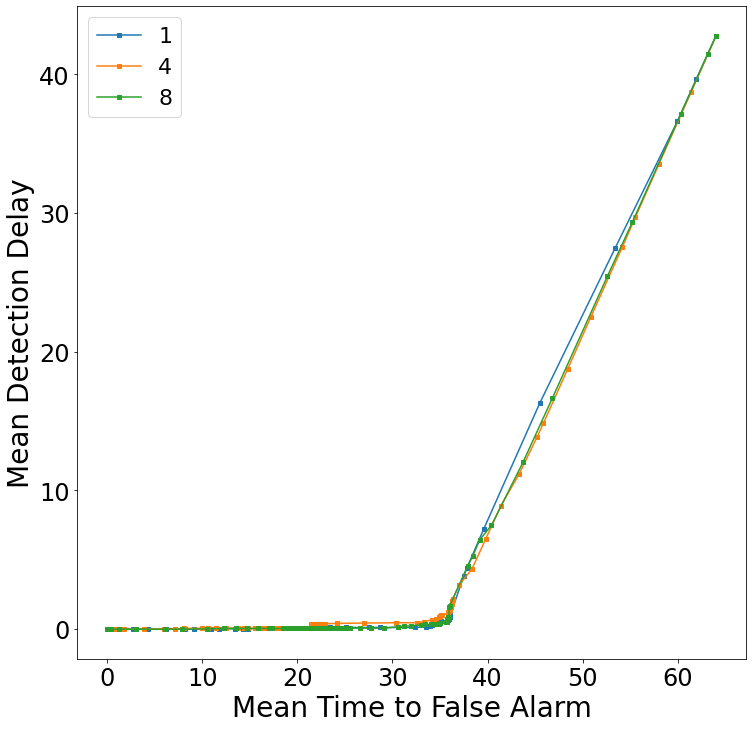

In [85]:
plt.figure(figsize=(12, 12))
for w in [1, 4, 8]:
    fp_delay_list_LSTM_custom, delay_list_LSTM_custom = w_dict_metrics[w]
    plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-s', markersize=4, label=w)

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=22);
#plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')

In [86]:
torch.save(w_dict_metrics, 'pick_w.pth')

In [87]:
w_dict_auc

{8: 611.5062881097562,
 16: 617.1865472560975,
 24: 607.0825076219512,
 32: 608.7551448170732,
 40: 617.0691692073171,
 48: 606.9030106707316,
 56: 611.9681783536586,
 64: 606.5533536585367,
 1: 631.1993140243902,
 2: 609.5676448170732,
 3: 614.1532012195122,
 4: 610.2456173780488,
 5: 600.3410823170732,
 6: 611.1209984756098,
 7: 628.670350609756}